In [30]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import scipy.stats as scipy
import scipy.signal as signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 5)})
sns.set_style("whitegrid", {'axes.grid' : False})
import datetime
import warnings
warnings.filterwarnings('ignore')
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
cRange = ['#475468', '#e7e6e6', '#4b73be', '#df8244', '#a5a5a5', '#f7c143',
          '#20406a', '#deeef8', '#2d6fc0', '#409cd4', '#5ccdd7', '#5ecb9e',
          '#a53218', '#c59933', '#f08a40', '#aa4f30', '#f7bf5d', '#d85733',
          '#728083', '#8babb4', '#7196ad', '#607397', '#8585c2', '#a687c1']
colors = ['#475468', '#e7e6e6', '#4b73be', 
          '#df8244', '#a5a5a5', '#f7c143'] 
cmapOffice = mpl.colors.ListedColormap([cRange[i] for i in range(0, 5)])
cmapBlue = mpl.colors.ListedColormap([cRange[i] for i in range(6, 11)])
cmapRed = mpl.colors.ListedColormap([cRange[i] for i in range(12, 17)])
cmapViolett = mpl.colors.ListedColormap([cRange[i] for i in range(18, 23)])



Current correlation method is: pearson
(can be emtpy) Current label prefix is: 



Correlation of Price Difference & Wind Forecast Error: -0.3940734957646056
Correlation of Price Difference & Solar Forecast Error: -0.21789173437621973
Correlation of Price Difference & Total Forecast Error: -0.44817361320180726


Total_FE: Ttest_indResult(statistic=-7.989127298000389, pvalue=1.4002168569645373e-15)
Total_FE: Ttest_relResult(statistic=-7.974382305829369, pvalue=1.6249951868059867e-15)


Wind_FE: Ttest_indResult(statistic=-11.042992533979676, pvalue=2.6389280873882815e-28)
Wind_FE: Ttest_relResult(statistic=-11.023238014814847, pvalue=3.6529655657385303e-28)


Solar_FE: Ttest_indResult(statistic=4.9120345963957, pvalue=9.054132378579567e-07)
Solar_FE: Ttest_relResult(statistic=4.90144562882659, pvalue=9.598369068156245e-07)





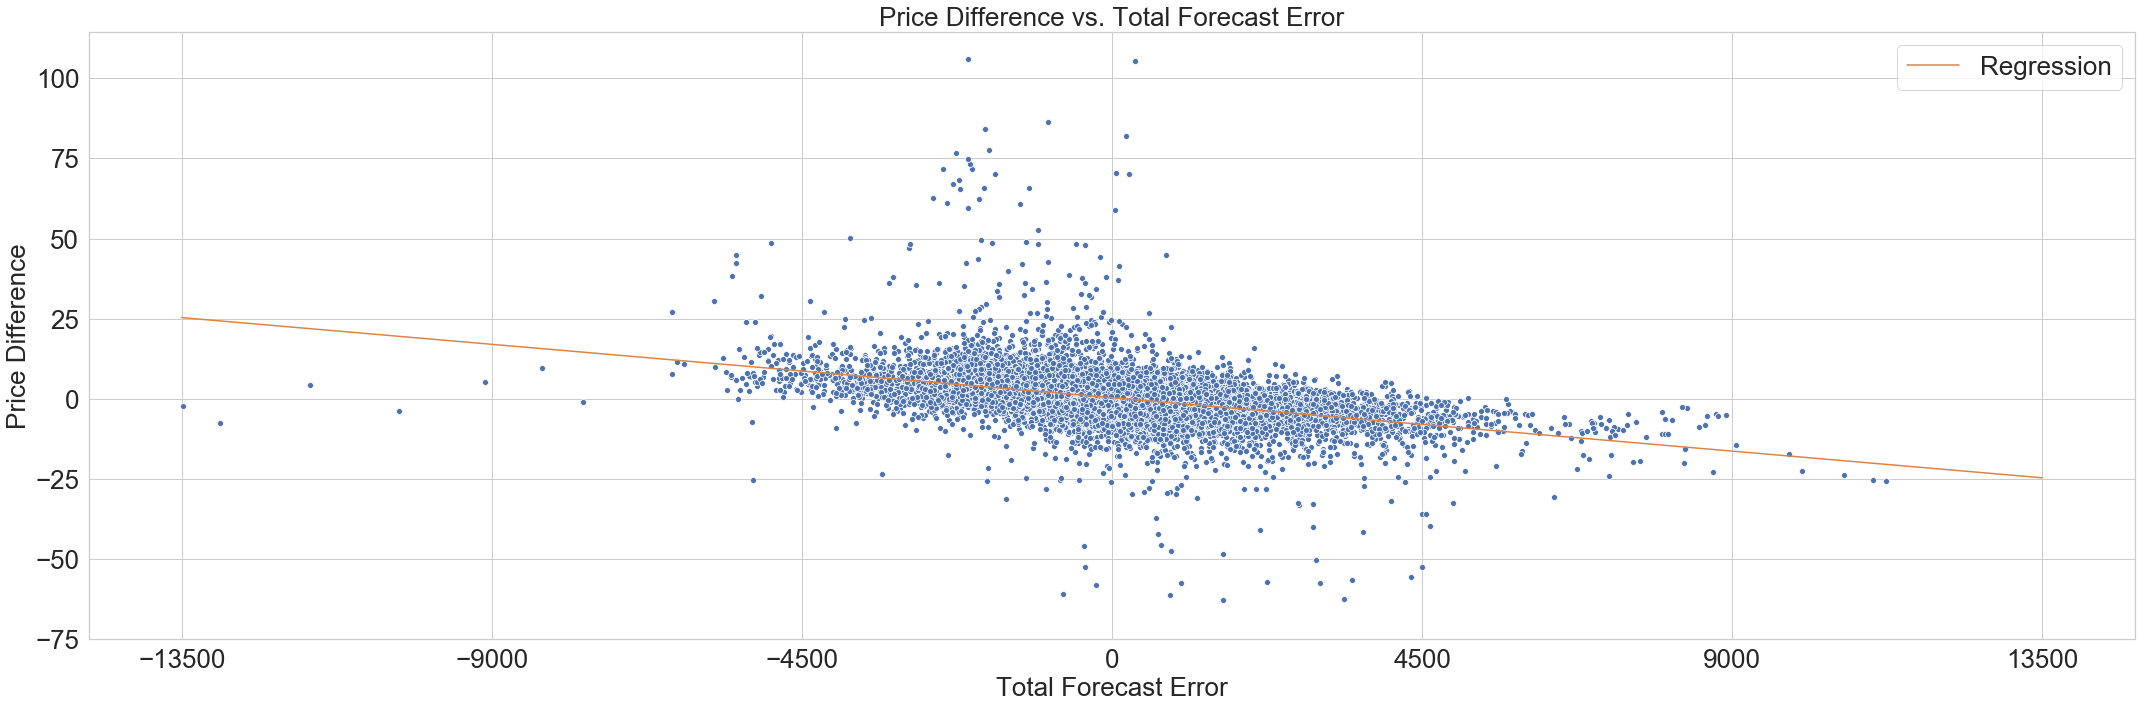

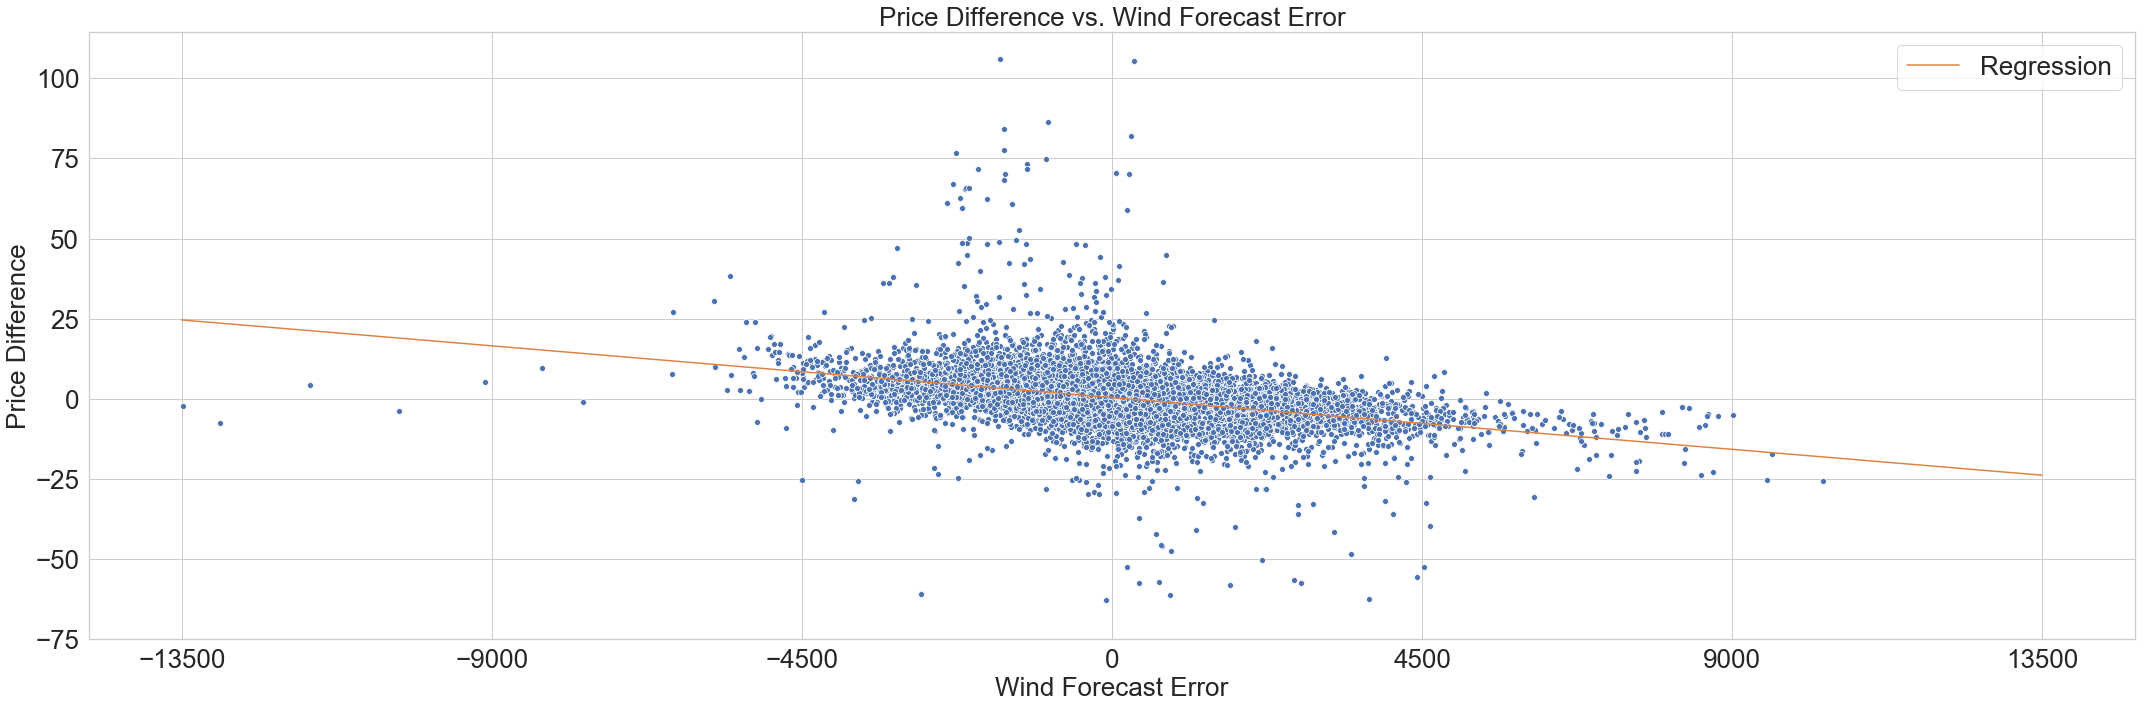

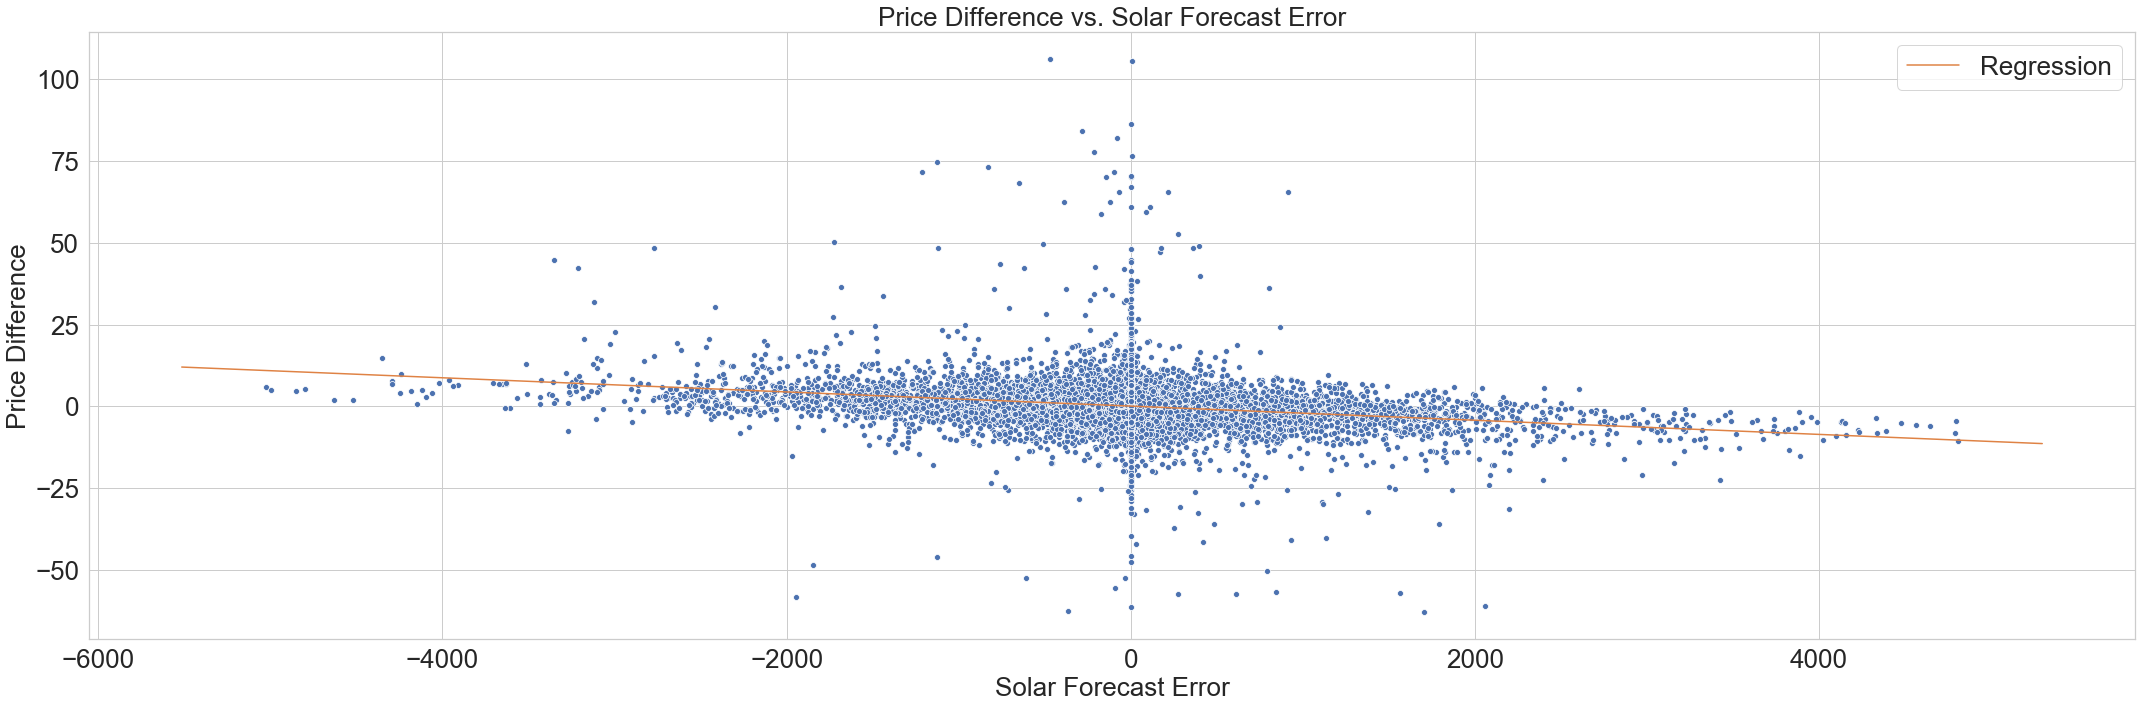

In [49]:
fullData = pd.read_csv("../00_data/data_with_calc_fields.csv", sep=";", decimal=",", index_col="datetime")
fullData.index = pd.to_datetime(fullData.index)

fullData["mov_avg_30_price_diff"] = fullData["price_diff"].ewm(span=30*24,  min_periods=1).mean()

corrMethod = "pearson" # pearson // spearman // kendall

labelPrefix = "" # e.g. mov_avg_30_ // or leave empty (no space)
forecastErrorLabel_total = labelPrefix + "forecast_error"
forecastErrorLabel_wind = labelPrefix + "wind_forecast_error"
forecastErrorLabel_solar = labelPrefix + "solar_forecast_error"
priceDiffLabel = labelPrefix + "price_diff"

print("\n")
print("Current correlation method is: " + corrMethod)
print("(can be emtpy) Current label prefix is: " + labelPrefix)
print("\n\n")

series_forecastError_wind = fullData[forecastErrorLabel_wind]
series_forecastError_solar = fullData[forecastErrorLabel_solar]
series_forecastError_total = fullData[forecastErrorLabel_total]
series_priceDifference = fullData[priceDiffLabel]

corrCoeff_price_wind = series_priceDifference.corr(series_forecastError_wind, method=corrMethod)
corrCoeff_price_solar = series_priceDifference.corr(series_forecastError_solar, method=corrMethod)
corrCoeff_price_total = series_priceDifference.corr(series_forecastError_total, method=corrMethod)

print("Correlation of Price Difference & Wind Forecast Error: " + str(corrCoeff_price_wind))
print("Correlation of Price Difference & Solar Forecast Error: " + str(corrCoeff_price_solar))
print("Correlation of Price Difference & Total Forecast Error: " + str(corrCoeff_price_total))

# slope_total, intercept_total, rvalue_total, pvalue_total, stderr_total = linregress(series_forecastError_total, series_priceDifference)
# slope_wind, intercept_wind, rvalue_wind, pvalue_wind, stderr_wind = linregress(series_forecastError_wind, series_priceDifference)
# slope_solar, intercept_solar, rvalue_solar, pvalue_solar, stderr_solar = linregress(series_forecastError_solar, series_priceDifference)

total_FE_reg = LinearRegression(fit_intercept=True, normalize=True)
total_FE_reg.fit(series_forecastError_total.as_matrix().reshape(-1, 1), series_priceDifference.as_matrix().reshape(-1, 1))
slope_total = total_FE_reg.coef_[0]
intercept_total = total_FE_reg.intercept_

wind_FE_reg = LinearRegression(fit_intercept=True, normalize=True)
wind_FE_reg.fit(series_forecastError_wind.as_matrix().reshape(-1, 1), series_priceDifference.as_matrix().reshape(-1, 1))
slope_wind = wind_FE_reg.coef_[0]
intercept_wind = wind_FE_reg.intercept_

solar_FE_reg = LinearRegression(fit_intercept=True, normalize=True)
solar_FE_reg.fit(series_forecastError_solar.as_matrix().reshape(-1, 1), series_priceDifference.as_matrix().reshape(-1, 1))
slope_solar = solar_FE_reg.coef_[0]
intercept_solar = solar_FE_reg.intercept_

print("\n")
print("Total_FE: " + str(scipy.ttest_ind(series_priceDifference, series_forecastError_total)))
print("Total_FE: " + str(scipy.ttest_rel(series_priceDifference, series_forecastError_total)))
print("\n")
print("Wind_FE: " + str(scipy.ttest_ind(series_priceDifference, series_forecastError_wind)))
print("Wind_FE: " + str(scipy.ttest_rel(series_priceDifference, series_forecastError_wind)))
print("\n")
print("Solar_FE: " + str(scipy.ttest_ind(series_priceDifference, series_forecastError_solar)))
print("Solar_FE: " + str(scipy.ttest_rel(series_priceDifference, series_forecastError_solar)))

chartFontSize = 26

x_lim_neg = -13500
x_lim_pos = 13501
x_step = 4500

y_lim_neg = -75
y_lim_pos = 125
y_step = 25

print("\n\n")

# total
fig1, (ax1) = plt.subplots(1, 1, figsize=(30, 10))

sns.scatterplot(x=forecastErrorLabel_total, y=priceDiffLabel, data=fullData, ax=ax1, label=None, ci=None)

x_vals_total = np.arange(x_lim_neg, x_lim_pos)
y_vals_total = intercept_total + slope_total * x_vals_total
sns.lineplot(x=x_vals_total, y=y_vals_total, ax=ax1, label="Regression", ci=None)

ax1.legend(prop={'size': chartFontSize})
ax1.grid(True)
ax1.set_title("Price Difference vs. Total Forecast Error")
ax1.set_xlabel("Total Forecast Error")
ax1.set_ylabel("Price Difference")
ax1.tick_params(axis='both', which='both', labelbottom=True)
ax1.set_xticks(np.arange(x_lim_neg, x_lim_pos, step=x_step))
ax1.set_yticks(np.arange(y_lim_neg, y_lim_pos, step=y_step))
for child in ax1.findobj(Line2D):
    if child.get_label() == "Regression":
        child.set_color(cRange[3])
# set font size of all elements
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()): item.set_fontsize(chartFontSize)

plt.tight_layout()
plt.show();

print("\n")

# wind
fig2, (ax2) = plt.subplots(1, 1, figsize=(30, 10))

sns.scatterplot(x=forecastErrorLabel_wind, y=priceDiffLabel, data=fullData, ax=ax2, label=None, ci=None)

x_vals_wind = np.arange(x_lim_neg, x_lim_pos)
y_vals_wind = intercept_wind + slope_wind * x_vals_wind
sns.lineplot(x=x_vals_wind, y=y_vals_wind, ax=ax2, label="Regression", ci=None)

ax2.legend(prop={'size': chartFontSize})
ax2.grid(True)
ax2.set_title("Price Difference vs. Wind Forecast Error")
ax2.set_xlabel("Wind Forecast Error")
ax2.set_ylabel("Price Difference")
ax2.tick_params(axis='both', which='both', labelbottom=True)
ax2.set_xticks(np.arange(x_lim_neg, x_lim_pos, step=x_step))
ax2.set_yticks(np.arange(y_lim_neg, y_lim_pos, step=y_step))
for child in ax2.findobj(Line2D):
    if child.get_label() == "Regression":
        child.set_color(cRange[3])
# set font size of all elements
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()): item.set_fontsize(chartFontSize)

plt.tight_layout()
plt.show();

print("\n")
    
# solar
fig3, (ax3) = plt.subplots(1, 1, figsize=(30, 10))

sns.scatterplot(x=forecastErrorLabel_solar, y=priceDiffLabel, data=fullData, ax=ax3, label=None, ci=None)
left, right = ax3.get_xlim()
x_vals_solar = np.arange(left, right)
# x_vals_solar = np.arange(x_lim_neg, x_lim_pos)
y_vals_solar = intercept_solar + slope_solar * x_vals_solar
sns.lineplot(x=x_vals_solar, y=y_vals_solar, ax=ax3, label="Regression", ci=None)

ax3.legend(prop={'size': chartFontSize})
ax3.grid(True)
ax3.set_title("Price Difference vs. Solar Forecast Error")
ax3.set_xlabel("Solar Forecast Error")
ax3.set_ylabel("Price Difference")
ax3.tick_params(axis='both', which='both', labelbottom=True)
# ax3.set_xticks(np.arange(x_lim_neg, x_lim_pos, step=x_step))
# ax3.set_yticks(np.arange(y_lim_neg, y_lim_pos, step=y_step))
for child in ax3.findobj(Line2D):
    if child.get_label() == "Regression":
        child.set_color(cRange[3])
# set font size of all elements
for item in ([ax3.title, ax3.xaxis.label, ax3.yaxis.label] +
             ax3.get_xticklabels() + ax3.get_yticklabels()): item.set_fontsize(chartFontSize)

plt.tight_layout()
plt.show();

# Conclusion

Since the correlation coefficient is negative, a positive addition to the forecast error leads to a negative addition to the price difference.
         
- Positive addition to the FE (increase in production or reduction of forecasted amount) leads to negative addition to the PD:
    - PD was >= 0: (price increases toward intraday)
        - price increases less // PD might shift from being >= 0 to being < 0 --> then: price decreases & PD < 0
    - PD was < 0:(price decreases toward intraday)
        - price decrease more (PD stays in the range of < 0)
- Negative addition to the FE (reduction in production or increase of forecasted amount) leads to positive addition to the PD:
    - PD was >= 0: (price increases toward intraday)
        - price increases more (PD stays in the range >= 0)
    - PD was < 0:(price decreases toward intraday)
        - price decreases less // PD might shift from being < 0 to being >= 0 --> then: price increases & PD >= 0    
        
        
For the first order differences (i.e. seasonality component) the correlation between FE and PD is lower than the "full" correlation.

For the mov_avg_30 (i.e. trend component) the correlation between FE and PD is higher than the "full" correlation.

==> assumption: the trend component has a higher influence than the seasonality component.

Correlation of solar_FE with PD is smaller than wind_FE with PD because the solar_FE data contains a large amount of zero-values for timeslots with no sunshine.